# DAY10 python 실습 노트

### 데이콘 서울시 평균 기온 예측 해커톤

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# !apt -qq -y install fonts-nanum
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
import warnings

# 모든 경고 무시
warnings.filterwarnings("ignore")


from matplotlib import font_manager


# font_manager.FontProperties(fname='/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf')
# plt.rcParams['font.family'] = 'NanumGothic'



# plt.rc('font', family='NanumGothic')

In [32]:
import pandas as pd

# 데이터 불러오기
train_df = pd.read_csv(train_path)
submission_df = pd.read_csv(submission_path)

display(train_df.head())
display(submission_df.head())
df1.head()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6


,일시,평균기온
0,2023-01-01,0
1,2023-01-02,0
2,2023-01-03,0
3,2023-01-04,0
4,2023-01-05,0


,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
일시,,,,,,,,,,
1960-01-01,2.2,-5.2,7.4,9.593683,68.3,1.7,6.7,11.93317,48.653526,-1.6
1960-01-02,1.2,-5.6,6.8,0.400000,87.7,1.3,0.0,11.93317,48.653526,-1.9
1960-01-03,8.7,-2.1,10.8,0.000000,81.3,3.0,0.0,11.93317,48.653526,4.0
1960-01-04,10.8,1.2,9.6,0.000000,79.7,4.4,2.6,11.93317,48.653526,7.5
1960-01-05,1.3,-8.2,9.5,9.593683,44.0,5.1,8.2,11.93317,48.653526,-4.6


In [33]:
train_df.isnull().sum()

일시          0
최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64

In [34]:
train_df['최고기온'].fillna(method='bfill', inplace=True)  # 뒤의 값으로 대체
train_df['최저기온'].fillna(method='bfill', inplace=True)
train_df['일교차'].fillna(method='bfill', inplace=True)
train_df['강수량'].fillna(method='bfill', inplace=True)
train_df['평균풍속'].fillna(method='bfill', inplace=True)
train_df['일조합'].fillna(method='bfill', inplace=True)
train_df['일사합'].fillna(method='bfill', inplace=True)
train_df['일조율'].fillna(method='bfill', inplace=True)

# 날짜 데이터 변환
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df = train_df.set_index('일시')

# 데이터의 시간 간격 지정
train_df.index.freq = 'D'

# 일시 컬럼이 인덱스로 할당됩니다.
train_df.head()



,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
일시,,,,,,,,,,
1960-01-01,2.2,-5.2,7.4,0.4,68.3,1.7,6.7,4.81,28.1,-1.6
1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,4.81,28.1,-1.9
1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,4.81,28.1,4.0
1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,4.81,28.1,7.5
1960-01-05,1.3,-8.2,9.5,0.0,44.0,5.1,8.2,4.81,28.1,-4.6


In [35]:
train_df['강수량'].fillna(method='ffill', inplace=True)
train_df['일사합'].fillna(method='ffill', inplace=True)
train_df['일조율'].fillna(method='ffill', inplace=True)

In [36]:
from statsmodels.tsa.stattools import kpss

kpss(train_df['평균기온'])

#  0.11213156818511481(p-value) > 0.05 -> 시계열 데이터가 안정적이지 않다는 대립가설을 기각하여 다른 처리는 불필요해보임

# p-value: p-value가 유의수준(일반적으로 0.05 또는 0.1)보다 작으면 귀무가설을 기각하고,
# 시계열이 정상성을 가지지 않는다는 것을 의미합니다. 반대로 p-value가 유의수준보다 크면 귀무가설을 채택하고, 시계열이 정상성을 가진다는 것을 의미합니다.

<ipython-input-36-b7a535a5d078>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(train_df['평균기온'])


(0.11213156818511481,
 0.1,
 90,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

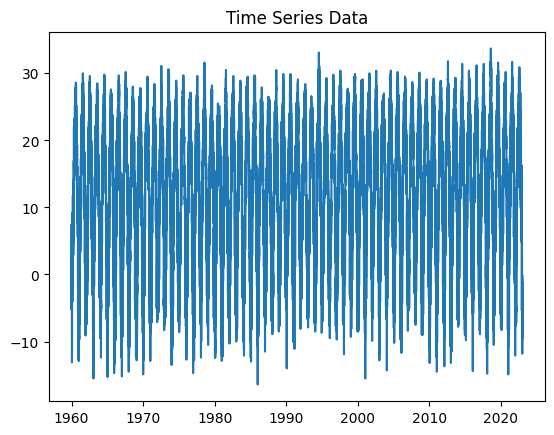

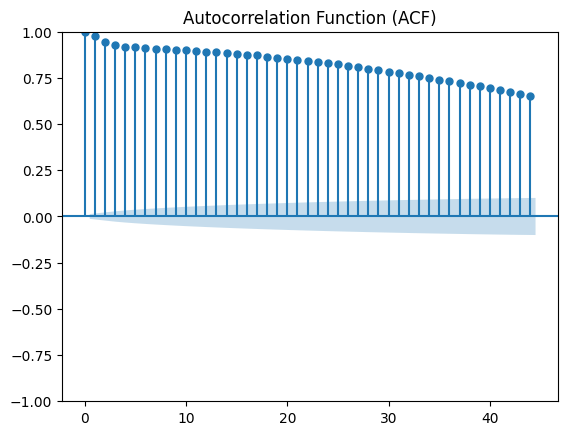

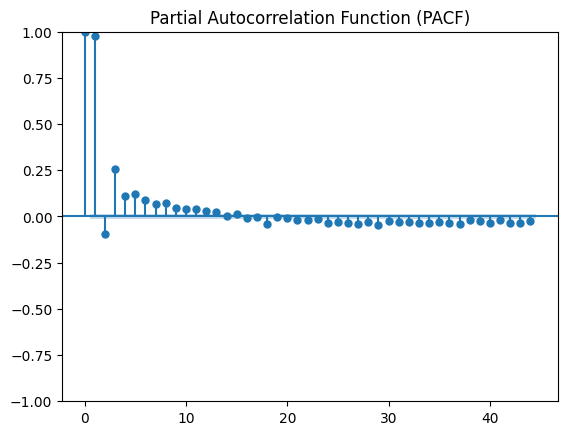

In [39]:

# 시계열 데이터 시각화
plt.plot(train_df['평균기온'])
plt.title('Time Series Data')
plt.show()

# ACF와 PACF 플롯
plot_acf(train_df['평균기온'])
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(train_df['평균기온'])
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


# 평균기온의 플랏을 봤을 때, 시계열 데이터의 정상성이 확보됐다고 볼 수 있음
# ACF 그래프를 봤을 때, 자기 상관성이 있는 데이터로 보임 시차가 있는 데이터
# PACF 를 보면 튀는 부분이 1개 ~ 2개 있으므로 AR1 또는 AR2 모델을 사용하는 것이 좋아보인다.


In [21]:
# !apt -qq -y install fonts-nanum
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf





# plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
# # 상관 행렬 계산
# correlation_matrix = train_df.corr()
# plt.rc('font', family='Nanum')
# # 히트맵으로 상관 관계 시각화
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Heatmap')
# plt.show()

In [ ]:
# plt.rc('font', family='NanumBarunGothic')
# # 설명변수와 예측변수 간의 산점도 행렬
# sns.pairplot(train_df, x_vars=['최고기온', '최저기온', '일교차', '강수량', '평균습도', '평균풍속', '일조합', '일사합', '일조율'], y_vars=['평균기온'])
# plt.suptitle('Scatter Plots between Features and Average Temperature', y=1.02)
# plt.show()


In [ ]:
p = 1
d = 1
q = 2

# ARIMA 모델 생성 및 피팅
order = (p, d, q)  # p: AR 차수, d: 차분 차수, q: MA 차수
model_df1 = ARIMA(df1['평균기온'], order=order)
results_df1 = model_df1.fit()

# 모델 예측
forecast_steps = 10
forecast = results_df1.get_forecast(steps=forecast_steps)
forecast_index = range(len(df1), len(df1) + forecast_steps)

# 결과 시각화
plt.plot(df1['평균기온'], label='Observed')
plt.plot(forecast_index, forecast.predicted_mean, color='red', label='Forecast')
plt.fill_between(forecast_index, forecast.conf_int()['lower 평균기온'], forecast.conf_int()['upper 평균기온'], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

## 데이콘 해커톤 실습

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc


In [2]:
# setup
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

info_path = '/content/drive/MyDrive/open_jeju/data_info.csv'
train_path = '/content/drive/MyDrive/open_jeju/train.csv'
test_path = '/content/drive/MyDrive/open_jeju/test.csv'
subm_path = '/content/drive/MyDrive/open_jeju/sample_submission.csv'

In [16]:
def data_preprocessing(train,test): #parquet로 바꿔서 train 하나 test하나 가지고 있어야함.
    #이상치 제거
    train_filtered = train[train['target'] <= 80]


    # 오브젝트 컬럼들 인코딩
    str_col = ['day_of_week','start_turn_restricted','end_turn_restricted']
    for i in str_col:
        le = LabelEncoder()
        le=le.fit(train_filtered[i])
        train_filtered[i]=le.transform(train_filtered[i])

    for label in np.unique(test[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

    # 피처 드랍 X Y 나누기
    y_train = train_filtered['target']

    X_train = train_filtered.drop(['id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted','day_of_week','target'], axis=1)

    test_drop = test.drop(['id','base_date', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted','day_of_week'], axis=1)

    print("X_train.shape: ", X_train.shape)
    print("y_train.shape: ", y_train.shape)
    print("test_drop.shape: ",test_drop.shape)



    return X_train, y_train, test_drop

In [4]:
# -> 메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업이 가능합니다.
csv_to_parquet(train_path, 'train')
csv_to_parquet(test_path, 'test')

train Done.
test Done.


In [12]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')

여기까지는 실행해야함

In [6]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [94]:
# columns INFO
INFO = pd.read_csv(info_path)
INFO

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [93]:
# 결측치 없음 // 오브젝트 타입 다수 //
train.info()
print(train.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [18]:
# 'base_date' 컬럼을 datetime 형식으로 변환
train['base_date'] = pd.to_datetime(train['base_date'], format='%Y%m%d')

# 'year'와 'month' 컬럼 추가
train['year'] = train['base_date'].dt.year
train['month'] = train['base_date'].dt.month

In [20]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,year,month
0,TRAIN_0000000,2022-06-23,목,17,1,106,지방도1112호선,0,0,60.0,...,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,2022,6
1,TRAIN_0000001,2022-07-28,목,21,2,103,일반국도11호선,0,0,60.0,...,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,2022,7
2,TRAIN_0000002,2021-10-10,일,7,2,103,일반국도16호선,0,0,80.0,...,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,2021,10
3,TRAIN_0000003,2022-03-11,금,13,2,107,태평로,0,0,50.0,...,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,2022,3
4,TRAIN_0000004,2021-10-05,화,8,2,103,일반국도12호선,0,0,80.0,...,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,2021,10


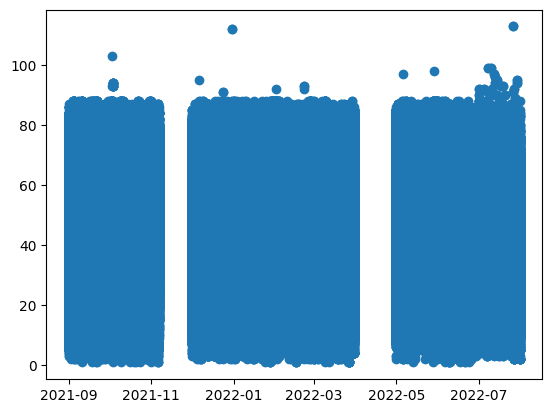

{2021, 2022}
{1, 2, 3, 5, 6, 7, 9, 10, 11, 12}


In [22]:
plt.rcdefaults()
plt.scatter(train.base_date,train.target)
plt.show()
# 2021년에는 9,10,11  2022년에는 1,2,3   5,6,7 월
# 산점도를 보니 몇몇 이상치들이 보임.

print(set(train.year))
print(set(train.month))

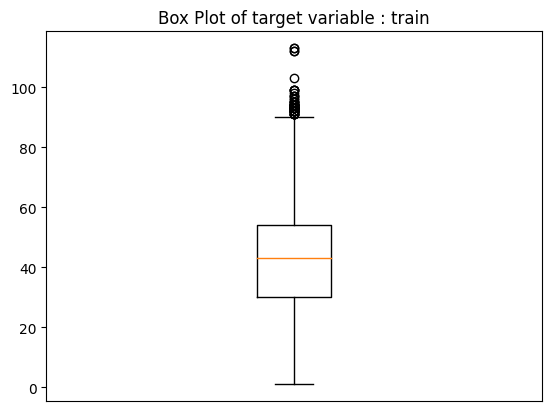

In [107]:
plt.boxplot(train.target)
plt.xticks([])
plt.title('Box Plot of target variable : train')
plt.show()

# box plot을 target 변수에 그려본 결과 이상치들이 IQR 울타리 밖 존재 이상치들은 제거할지 스케일 맞춰줄지 결정해야함.
# target 변수는 해당 도로에서의 차량 스피드를 나타냄. 경험상 제주도에는 80이상 달릴 수 있는 곳이 별로 없음 .
# 컬럼중에 maximum_speed_limit 컬럼이 있으니 확인

In [108]:
# max_speed_limit 확인
print(train.maximum_speed_limit.max())
# 80이 최대 제한 속도이므로 80이상의 데이터의 수를 보고 적은 경우 제거하기로 결정

80.0


In [117]:
cnt = len(train[train['target'] > 80]) # 26239
total = len(train)
print('이상치가 전체 데이터에서 차지하는 비율 : {:.2f}%'.format((cnt/total)*100))
print('total number of data : {}'.format(total))
# 전체 데이터 수가 많기 때문에 제거하기로 결정

0.5581320751626653
이상치가 전체 데이터에서 차지하는 비율 : 0.56%
total number of data : 4701217


In [23]:
train_filtered = train[train['target'] <= 80]
len(train_filtered)
print("이상치 제거 후 전체 데이터의 수 : {}".format(len(train_filtered)))
train_filtered.head()

이상치 제거 후 전체 데이터의 수 : 4674978


,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,year,month
0,TRAIN_0000000,2022-06-23,목,17,1,106,지방도1112호선,0,0,60.0,...,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0,2022,6
1,TRAIN_0000001,2022-07-28,목,21,2,103,일반국도11호선,0,0,60.0,...,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0,2022,7
2,TRAIN_0000002,2021-10-10,일,7,2,103,일반국도16호선,0,0,80.0,...,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0,2021,10
3,TRAIN_0000003,2022-03-11,금,13,2,107,태평로,0,0,50.0,...,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0,2022,3
4,TRAIN_0000004,2021-10-05,화,8,2,103,일반국도12호선,0,0,80.0,...,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0,2021,10


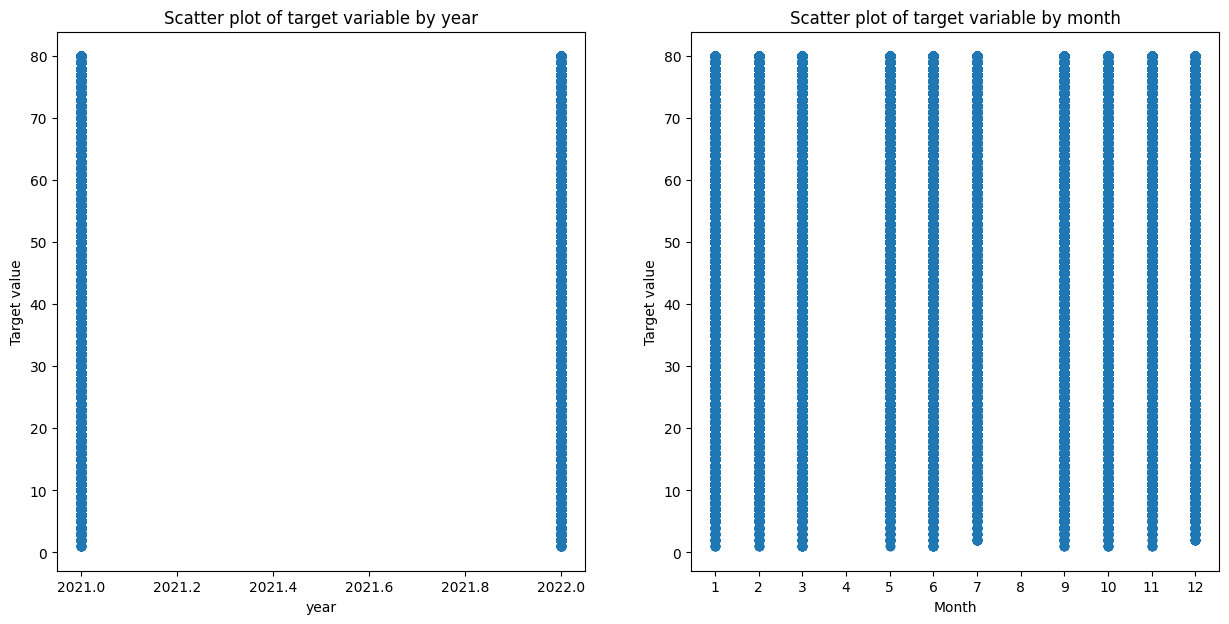

In [29]:
plt.figure(figsize = (15,7))

plt.subplot(1,2,1)
plt.title("Scatter plot of target variable by year")
# sns.violinplot(x='year', y='target', data=train_filtered, color='skyblue', inner=None, ax=plt.gca())
plt.scatter(train_filtered.year,train_filtered.target)
# sns.scatterplot(x='year',y='target',data=train_filtered)
plt.ylabel('Target value')
plt.xlabel('year')


plt.subplot(1,2,2)
plt.title("Scatter plot of target variable by month")
plt.scatter(train_filtered.month,train_filtered.target)
# sns.violinplot(x='month', y='target', data=train_filtered, color='skyblue', inner=None, ax=plt.gca())
plt.xticks(range(1, 13))
plt.ylabel('Target value')
plt.xlabel('Month')



plt.show()

#연도별, 월별 타겟 값에 대한 분포 차이가 없으므로 연도와 월은 feature에서 뺀다.  하나의 str 컬럼이었던 base_date, year, month 모두 제거

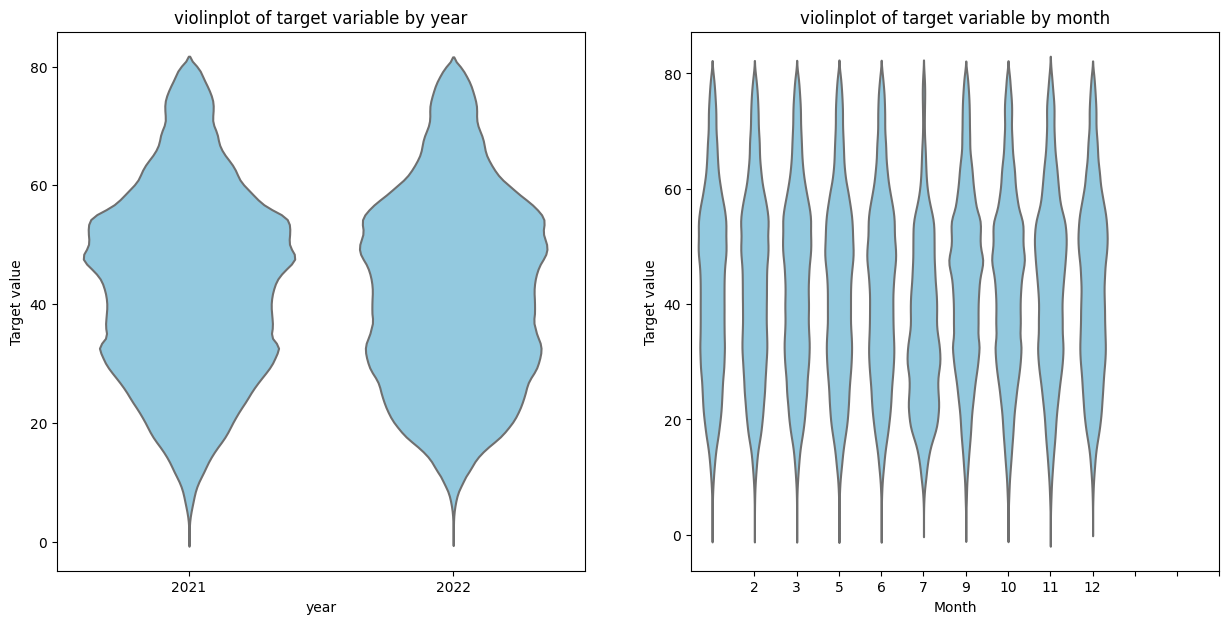

In [30]:
plt.figure(figsize = (15,7))

plt.subplot(1,2,1)
plt.title("violinplot of target variable by year")
sns.violinplot(x='year', y='target', data=train_filtered, color='skyblue', inner=None, ax=plt.gca())
# plt.scatter(train_filtered.year,train_filtered.target)
# sns.scatterplot(x='year',y='target',data=train_filtered)
plt.ylabel('Target value')
plt.xlabel('year')


plt.subplot(1,2,2)
plt.title("violinplot of target variable by month")
# plt.scatter(train_filtered.month,train_filtered.target)
sns.violinplot(x='month', y='target', data=train_filtered, color='skyblue', inner=None, ax=plt.gca())
plt.xticks(range(1, 13))
plt.ylabel('Target value')
plt.xlabel('Month')



plt.show()

#연도별, 월별 타겟 값에 대한 분포 차이가 없으므로 연도와 월은 feature에서 뺀다.  하나의 str 컬럼이었던 base_date, year, month 모두 제거

In [31]:
# 한글 요일을 영어로 매핑하는 딕셔너리 생성
day_mapping = {'월': 'Mon', '화': 'Tue', '수': 'Wed', '목': 'Thu', '금': 'Fri', '토': 'Sat', '일': 'Sun'}

# 'day_of_week' 컬럼 값 변경
train_filtered['day_of_week'] = train_filtered['day_of_week'].map(day_mapping)


<ipython-input-31-5b8c1ad94b51>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered['day_of_week'] = train_filtered['day_of_week'].map(day_mapping)


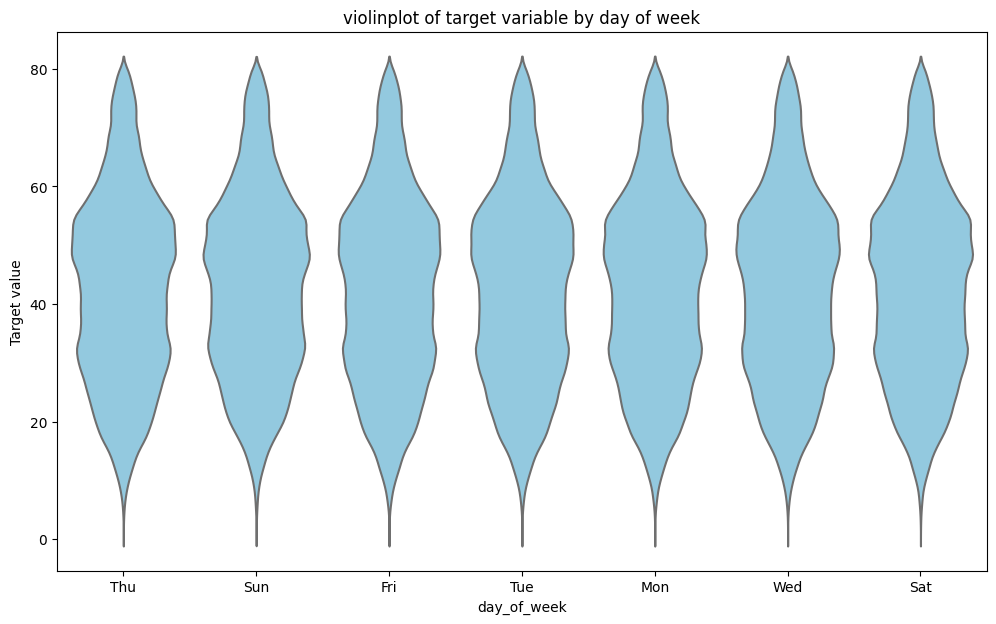

In [33]:
# 요일은 어떨까?
# plt.subplot(1,2,2)
plt.figure(figsize=(12,7))
plt.title("violinplot of target variable by day of week")
# plt.scatter(train_filtered.day_of_week,train_filtered.target)
sns.violinplot(x='day_of_week', y='target', data=train_filtered, color='skyblue', inner=None, ax=plt.gca())

# plt.xticks(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.ylabel('Target value')
plt.xlabel('day_of_week')
plt.show()

# 요일 역시 큰 차이를 보이지 않음. 즉 요일도 버림 판단.

In [130]:
# # 오브젝트 컬럼들 인코딩
# str_col = ['day_of_week','start_turn_restricted','end_turn_restricted']
# for i in str_col:
#     le = LabelEncoder()
#     le=le.fit(train_filtered[i])
#     train_filtered[i]=le.transform(train_filtered[i])

#     for label in np.unique(test[i]):
#         if label not in le.classes_:
#             le.classes_ = np.append(le.classes_, label)
#     test[i]=le.transform(test[i])

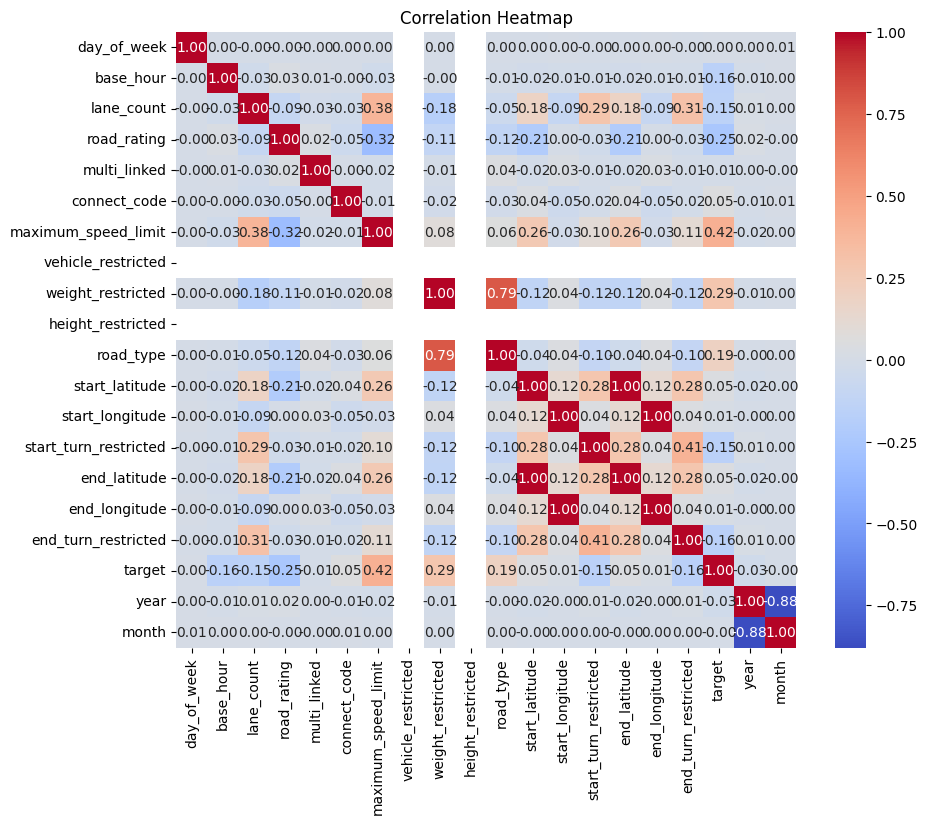

In [131]:
# # 상관 행렬 계산
correlation_matrix = train_filtered.corr()


# 히트맵으로 상관 관계 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

#대체적으로 target과의 상관계수가 다 약함


## 전처리 이후 시작

In [35]:
# -> 메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업이 가능합니다.

train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')

train Done.
test Done.


In [36]:
X_train,y_train,test = data_preprocessing(train,test)

<ipython-input-16-3bbc98e23ab7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered[i]=le.transform(train_filtered[i])
<ipython-input-16-3bbc98e23ab7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filtered[i]=le.transform(train_filtered[i])
<ipython-input-16-3bbc98e23ab7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

X_train.shape:  (4674978, 15)
y_train.shape:  (4674978,)
test_drop.shape:  (291241, 15)


### 모델링

In [37]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4674978 entries, 0 to 4701216
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   base_hour              int64  
 1   lane_count             int64  
 2   road_rating            int64  
 3   multi_linked           int64  
 4   connect_code           int64  
 5   maximum_speed_limit    float64
 6   weight_restricted      float64
 7   height_restricted      float64
 8   road_type              int64  
 9   start_latitude         float64
 10  start_longitude        float64
 11  start_turn_restricted  int64  
 12  end_latitude           float64
 13  end_longitude          float64
 14  end_turn_restricted    int64  
dtypes: float64(7), int64(8)
memory usage: 570.7 MB


In [38]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

In [ ]:
lr_reg = LinearRegression()
knn_reg = KNeighborsRegressor(n_neighbors=8)
rf_reg = RandomForestRegressor()
vo_reg = VotingRegressor(estimators=[("LR", lr_reg), ("KNN", knn_reg),("RANFOR",rf_reg)])


# 반복하여 정확도를 보면 각각의 알고리즘일 때 보다 보팅 형식으로 묶어 사용했을 때 정확도 상승


classifiers = [vo_reg, lr_reg, knn_reg,rf_reg]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(test)
    name = classifier.__class__.__name__


### 서브미션

In [ ]:
pred = vo_reg.predict(test)

In [ ]:
sample_submission = pd.read_csv(subm_path)

In [ ]:
sample_submission['target'] = pred
sample_submission.to_csv("./submit.csv", index = False)

In [ ]:
sample_submission

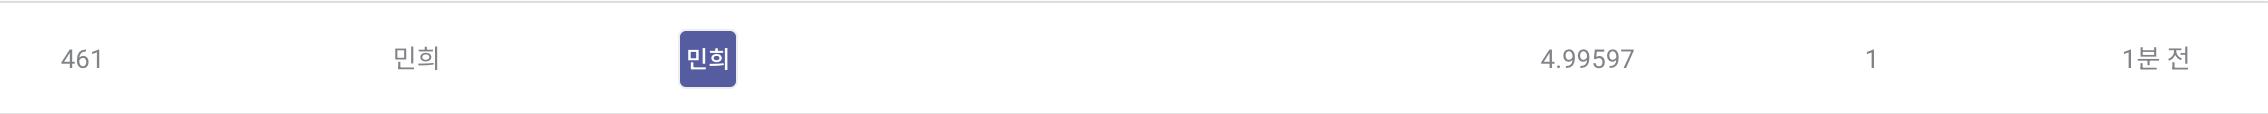

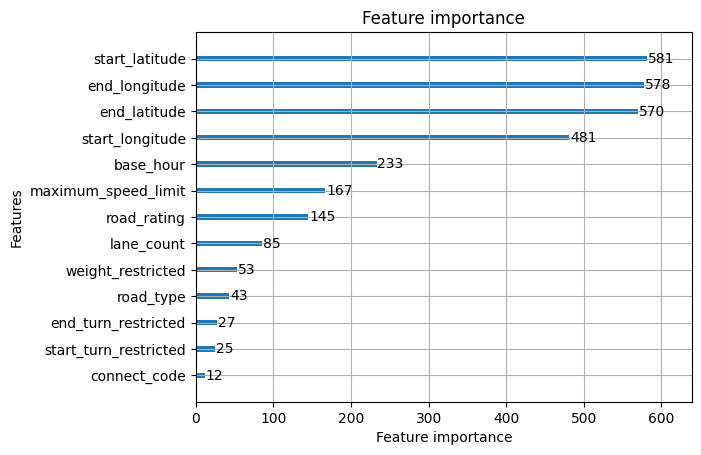

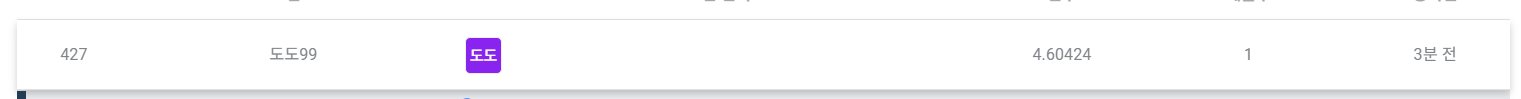